In [1]:
# %matplotlib notebook
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import cv2
from skimage import morphology
import pyprind
import tensorflow as tf
from keras import layers, losses, optimizers
from keras.models import *
from keras.layers import *
from keras.callbacks import EarlyStopping, Callback
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
np.set_printoptions(suppress=True)

Using TensorFlow backend.


## Calculating max and mean density and center of the scan volume.

In [0]:
class dicom_object(object):
    def __init__(self, image_path):
        self.image_path = image_path
        self.lis = [file for file in sorted(os.listdir(self.image_path))]
        
    ## Reading the files meta data
    def getmeta(self):
        f1 = self.lis[0]
        ds1 = pydicom.dcmread(self.image_path + '/' + f1)
        f2 = self.lis[1]
        ds2 = pydicom.dcmread(self.image_path + '/' + f2)
        xdim = int(ds1.Rows)
        ydim = int(ds1.Columns)
        slice_spacing = np.round(ds2.SliceLocation - ds1.SliceLocation, 5)
        pixel_spacing = float(ds1.PixelSpacing[0])
        slice_thickness = float(ds1.SliceThickness)

        print("Pixel sizes(x, y), Pixel spacing, Slice spacing, Slice thikness = " \
              + str(xdim) + ", " + str(ydim) + ", " + str(pixel_spacing) + ", " \
              + str(slice_spacing) + ", ", str(slice_thickness))
        print('Number of slices: {0}'.format(len(self.lis)))

        return [xdim, ydim, pixel_spacing, slice_spacing, slice_thickness, len(self.lis)]
    
    ## Hounsfield unit -2048 is the margins and therefore removed
    ## Getting mas density
    def get_max_intensity(self):
        num_files = len(self.lis)
        f1 = self.lis[0]
        ds1 = ds1 = pydicom.dcmread(self.image_path + '/' + f1)
        pix_array = ds1.pixel_array
        pix_array[pix_array == -2048] = 0
        max_intensity = pix_array.max()
        for i in range(1, num_files):
            f1 = self.lis[i]
            ds1 = ds1 = pydicom.dcmread(self.image_path + '/' + f1)
            pix_array = ds1.pixel_array
            pix_array[pix_array == -2048] = 0
            if pix_array.max() > max_intensity:
                max_intensity = pix_array.max()
        return max_intensity
    
    ## Getting mean density
    def get_mean_intensity(self):
        num_files = len(self.lis)
        f1 = self.lis[0]
        ds1 = ds1 = pydicom.dcmread(self.image_path + '/' + f1)
        pix_array = ds1.pixel_array
        pix_array[pix_array == -2048] = 0
        mean_intensity = pix_array.mean()
        for i in range(1, num_files):
            f1 = self.lis[i]
            ds1 = ds1 = pydicom.dcmread(self.image_path + '/' + f1)
            pix_array = ds1.pixel_array
            pix_array[pix_array == -2048] = 0
            mean_intensity += pix_array.mean()
        return int(np.round(mean_intensity / num_files, 7))
    
    ## Transformin from ijk to scanner coordinates using affine transformation
    ## This function first finds the middle slice in the scan and then calculates the center of the volume accordingly
    def get_center(self):
        meta = self.getmeta()
        x = meta[0] / 2
        y = meta[1] / 2
        ds = pydicom.dcmread(PATH + '/' + self.lis[int(len(self.lis)/2)])
        pos = self.affine_transform(x, y, ds)
        return pos
    
    ## Affine transformation function
    ## https://nipy.org/nibabel/dicom/dicom_orientation.html#dicom-slice-affine
    ## https://www.slicer.org/wiki/Coordinate_systems
    def affine_transform(self, x, y, scan):
        pos = [float(x) for x in scan.ImagePositionPatient]
        ori = [float(x) for x in scan.ImageOrientationPatient]
        pixel_spacing = float(scan.PixelSpacing[0])
        T = np.array(pos + [1])
        R = pixel_spacing * np.array(ori[0:3] + [0])
        C = pixel_spacing * np.array(ori[3:6] + [0])
        M = np.zeros((4, 4))
        M[:, 0] = R
        M[:, 1] = C
        M[:, 3] = T
        vox = np.array([x, y, 0, 1])
        return np.matmul(M, vox)[:3]

Image processing for detecting metal objects.
writes the output to binary mask files. Metals have much higher inensities compared to tissues and bones. 
Therefore thresholding and a morphology opening (erosion followed by dilation) is applicable

In [0]:
class mask_object(object):
    def __init__(self, image_path, out_path):
        self.image_path = image_path
        self.out_path = out_path
        self.lis = [file for file in sorted(os.listdir(self.image_path))]
        if not os.path.isdir(self.out_path):
            os.mkdir(self.out_path)
        
    def get_mask(self):
        prog = pyprind.ProgBar(len(self.lis), title='Processing images...')
        for file in self.lis:
            ds1 = pydicom.dcmread(self.image_path + '/' + file)
            image = ds1.pixel_array
            image[image == -2048] = 0
            image[image < 2500] = 0
            binary = np.where(image < 4000, 0, 1)
            binary = morphology.opening(binary)
            binary = np.where(binary == 0, 0, 255)
            cv2.imwrite(self.out_path + '/' + file + '.tif', binary)
            prog.update()

A U-net DNN class. U-net is an upgrade to previous networks such as FCNs (Fully convolutional networks),
and it is especifically designed for medical image segmentation.

 https://colab.research.google.com/drive/1BgCDxVdVc0MAe_kC0waMGUV9ShcWW0hM#scrollTo=hw66ln2H3YzQ
 
 https://github.com/zhixuhao/unet/blob/master/model.py
 
 https://www.kaggle.com/weiji14/yet-another-keras-u-net-data-augmentation

In [0]:
class unet_object(object):
    def __init__(self, 
                 image_path,
                 masks_path,
                 num_epochs = 10,
                 batch_size = 15,
                 learning_rate=0.0001,
                 dropout=0.5,
                 iou_metric=False,
                 height=512,
                 width=512,
                 dim=1):
        self.image_path = image_path
        self.masks_path = masks_path
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.dropout = dropout
        self.iou_metric = iou_metric
        self.height = height
        self.width = width
        self.dim = dim
        self.lis = [file for file in sorted(os.listdir(self.image_path))]
        self.UU = self.unet_unit(self.height, self.width, self.dim)
        optimizer = optimizers.Adam(self.learning_rate)
        
        if self.iou_metric:
            metric = [self.mean_iou]
        else:
            metric = ['accuracy']
            
        weights=np.array([1.0, 50.0])
        self.UU.compile(loss=self.weighted_categorical_crossentropy(weights), 
                        optimizer=optimizer, 
                        metrics=metric)

    ## downsampling function (Convolutional layer)
    def downsample_unit(self, dim):
        dsu = Conv2D(dim, 3, strides=1, padding='same', 
                     activation='relu',
                     kernel_initializer = 'he_normal')
        return dsu
    
    ## upsampling function (Deconvolution layer)
    def upsample_unit(self, dim):
        usu = Conv2DTranspose(dim, 3, strides=2, padding='same')
        return usu
    
    ## model structure
    def unet_unit(self, height, width, dim):
        uu = Sequential()
        
        # left
        input_shape = (height, width, dim)
        inputs = Input(input_shape)
        conv1 = self.downsample_unit(64)(inputs)
        conv1 = self.downsample_unit(64)(conv1)
        pool1 = MaxPooling2D(pool_size=2, strides=2, padding='valid')(conv1)
        
        conv2 = self.downsample_unit(128)(pool1)
        conv2 = self.downsample_unit(128)(conv2)
        pool2 = MaxPooling2D(pool_size=2, strides=2, padding='valid')(conv2)
        
        conv3 = self.downsample_unit(256)(pool2)
        conv3 = self.downsample_unit(256)(conv3)
        pool3 = MaxPooling2D(pool_size=2, strides=2, padding='valid')(conv3)

        conv4 = self.downsample_unit(512)(pool3)
        conv4 = self.downsample_unit(512)(conv4)
        drop4 = Dropout(self.dropout)(conv4)
        pool4 = MaxPooling2D(pool_size=2, strides=2, padding='valid')(drop4)
        
        conv5=self.downsample_unit(1024)(pool4)
        conv5=self.downsample_unit(1024)(conv5)
        drop5 = Dropout(self.dropout)(conv5)
        
        # right
        up6 = self.upsample_unit(512)(drop5)
        merge6 = concatenate([drop4,up6], axis = 3)
        conv6 = self.downsample_unit(512)(merge6)
        conv6 = self.downsample_unit(512)(conv6)
        
        up7 = self.upsample_unit(256)(conv6)
        merge7 = concatenate([conv3,up7], axis = 3)
        conv7 = self.downsample_unit(256)(merge7)
        conv7 = self.downsample_unit(256)(conv7)
        
        up8 = self.upsample_unit(128)(conv7)
        merge8 = concatenate([conv2,up8], axis = 3)
        conv8 = self.downsample_unit(128)(merge8)
        conv8 = self.downsample_unit(128)(conv8)
        
        up9 = self.upsample_unit(64)(conv8)
        merge9 = concatenate([conv1,up9], axis = 3)
        conv9 = self.downsample_unit(64)(merge9)
        conv9 = self.downsample_unit(64)(conv9)
        
        conv10 = self.downsample_unit(2)(conv9)
        conv11 = Conv2D(1, 1, activation = 'sigmoid')(conv10)
        
        uu = Model(input = inputs, output = conv11)
        return uu
    
    ## getting the ct images
    def get_image_stack(self):
        scans = [pydicom.dcmread(self.image_path + '/' + s) for s in self.lis]
        img = np.stack([s.pixel_array for s in scans])
        img[img == -2048] = 0
        img = np.stack([(x - x.min())/(x.max()-x.min()) - 0.5 for x in list(img)])
        img = img.astype(np.float32)
        return np.expand_dims(img, 3)
    
    ## getting the masks
    def get_masks_stack(self):
        masks_list = sorted(os.listdir(self.masks_path))
        masks = [plt.imread(self.masks_path + '/' + s) for s in masks_list]
        img = np.stack([s for s in masks])
        img = (img / 255).astype(np.float32)
        return np.expand_dims(img, 3)
    
    ## train function
    def train(self):
        train_generator, test_generator = self.get_augmented_data()
        self.UU.fit_generator(train_generator, validation_data=test_generator, 
                            validation_steps=self.batch_size/2,
                            steps_per_epoch=len(self.get_image_stack())/(self.batch_size*2), 
                            epochs=self.num_epochs)
        
    def predict(self, image_stack):
        scans = [pydicom.dcmread(self.image_path + '/' + s) for s in sorted(image_stack)]
        img = np.stack([s.pixel_array for s in scans])
        img[img == -2048] = 0
        img = np.stack([(x - x.min())/(x.max()-x.min()) for x in list(img)])
        img = img.astype(np.float32)
        img = np.expand_dims(img, 3)
        return np.squeeze(self.UU.predict(img, batch_size=len(img)))        
          
    ## https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
    ## Custom IoU metric. A metric for Intersection over Union. In object detection tasks,
    ## this metric provides a measure for evaluating how well the bounding or object box is fittes on the object
    def mean_iou(self, y_true, y_pred):
        prec = []
        for t in np.arange(0.5, 1.0, 0.05):
            y_pred_ = tf.to_int32(y_pred > t)
            score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
            K.get_session().run(tf.local_variables_initializer())
            with tf.control_dependencies([up_opt]):
                score = tf.identity(score)
                prec.append(score)
        return K.mean(K.stack(prec), axis=0) 

    ## https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
    ## A weighted cross entropy loss. This is required as there is a big class imbalance in the data
    def weighted_categorical_crossentropy(self, weights):
      
        weights = K.variable(weights)

        def loss(y_true, y_pred):
            # scale predictions so that the class probas of each sample sum to 1
            y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
            # clip to prevent NaN's and Inf's
            y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
            # calc
            loss = y_true * K.log(y_pred) * weights
            loss = -K.sum(loss, -1)
            return loss

        return loss
  
    ## data generator. 
    ## The number of images is not enough for training such a big DNN. 
    ## data augmentation is required. This function generates extra images and feeds to the DNN.
    def get_augmented_data(self):
        X_train, X_test, y_train, y_test = train_test_split(self.get_image_stack(),
                                                    self.get_masks_stack(),
                                                    test_size=0.1,
                                                    random_state=0)
        ## dictionary for image manipulation
        data_gen_args = dict(rotation_range=45.,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='reflect')
        X_gen = ImageDataGenerator(**data_gen_args)
        Y_gen = ImageDataGenerator(**data_gen_args)
        X_gen.fit(X_train, augment=True, seed=0)
        Y_gen.fit(y_train, augment=True, seed=0)
        X_train_augmented = X_gen.flow(X_train, batch_size=self.batch_size,
                                         shuffle=True, seed=0)
        Y_train_augmented = Y_gen.flow(y_train, batch_size=self.batch_size,
                                         shuffle=True, seed=0)
      
        X_val = ImageDataGenerator()
        Y_val = ImageDataGenerator()
        X_val.fit(X_test, augment=True, seed=0)
        Y_val.fit(y_test, augment=True, seed=0)
        X_test_augmented = X_val.flow(X_test, batch_size=self.batch_size, 
                                    shuffle=True, seed=0)
        Y_test_augmented = Y_val.flow(y_test, batch_size=self.batch_size, 
                                    shuffle=True, seed=0)
      
        train_generator = zip(X_train_augmented, Y_train_augmented)
        test_generator = zip(X_test_augmented, Y_test_augmented)
        return train_generator, test_generator

#### Euclidian distance is usually used as a measure for evaluating similarity between images.
#### Here for binary images it is basically equivalent to sum squared errors.

In [0]:
def get_mse(mask_path, out_path):
    error_list = []
    for file in sorted(os.listdir(mask_path)):
        mask = (plt.imread(mask_path + '/' + file) / 255).astype(int).flatten()
        out = (plt.imread(out_path + '/' + file)).astype(int).flatten()
        error_list.append(np.power(mask - out, 2).sum())
    return error_list

Image and mas paths.

In [0]:
PATH = 'ct'
OUT_PATH = 'masks'

Getting mmax, mean and scan centre

In [0]:
ob = dicom_object(PATH)
maxint = ob.get_max_intensity()
print('Scan max intensity is {0} Hounsfield units'.format(maxint))

meanint = ob.get_mean_intensity()
print('Scan mean intensity is {0} Hounsfield units'.format(meanint))

pos = ob.get_center()
print('Scan volume center is at x: {0}, y: {1}, z: {2}'.format(np.round(pos[0], 4), np.round(pos[1], 4), np.round(pos[2], 4)))

Scan max intensity is 20973 Hounsfield units
Scan mean intensity is -453 Hounsfield units
Pixel sizes(x, y), Pixel spacing, Slice spacing, Slice thikness = 512, 512, 0.976, 1.6,  2.0
Number of slices: 200
Scan volume center is at x: 0.8326, y: 28.1764, z: 1205.599


Image processing and storing masks

In [0]:
mo = mask_object(PATH, OUT_PATH)
mo.get_mask()

### U-net model

In [0]:
model = unet_object('ct', 'masks', num_epochs=5, batch_size=2, learning_rate=1e-8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [0]:
# model.UU.summary()

In [0]:
model.train()

Epoch 1/5
50/50 [==============================] - 33s 657ms/step - loss: 2.1946e-09 - acc: 0.8924 - val_loss: 1.7394e-09 - val_acc: 0.9067
Epoch 2/5
50/50 [==============================] - 28s 553ms/step - loss: 2.3177e-09 - acc: 0.8953 - val_loss: 0.0000e+00 - val_acc: 0.8235
Epoch 3/5
50/50 [==============================] - 27s 537ms/step - loss: 2.1308e-09 - acc: 0.8883 - val_loss: 2.3076e-09 - val_acc: 0.8488
Epoch 4/5
50/50 [==============================] - 27s 532ms/step - loss: 2.2986e-09 - acc: 0.8939 - val_loss: 1.7278e-09 - val_acc: 0.9627
Epoch 5/5
50/50 [==============================] - 27s 540ms/step - loss: 1.9199e-09 - acc: 0.8939 - val_loss: 3.0498e-09 - val_acc: 0.9888


Saving model weights for later use.

In [0]:
if not os.path.isdir('model20'):
    os.mkdir('model20')
model.UU.save_weights('model20/model20_weights.h5')

Saving the masks!

In [0]:
model = unet_object('ct', 'masks')
model.UU.load_weights('model20_weights.h5')

In [0]:
out_path = 'output'
lis = [file for file in sorted(os.listdir('ct'))]
if not os.path.isdir(out_path):
    os.mkdir(out_path)
for i in lis:
    out = model.predict([i])
    mask = np.where(out > 0.52, 1, 0)
    cv2.imwrite(out_path + '/' + i + '.tif', mask)

## Comparison between manual image processing (script) and U-net DNN

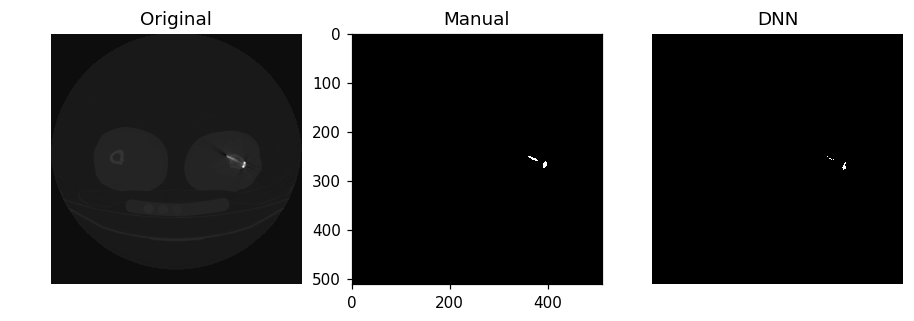

In [0]:
fig, axes = plt.subplots(ncols=3, figsize=(10, 5), dpi=110)
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

image = pydicom.dcmread('ct/IM00499')
ax[0].imshow(image.pixel_array, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

mask = plt.imread('masks/IM00499.tif')
ax[1].imshow(mask, cmap=plt.cm.gray)
ax[1].set_title('Manual')

generated = plt.imread('output/IM00499.tif')
ax[2].imshow(generated, cmap=plt.cm.gray)
ax[2].set_title('DNN')
ax[2].axis('off')

plt.show()

## Evaluating sum squared error and cross-scan errors between manual and DNN generated masks.

In [0]:
error = get_mse('masks', 'output')
print('Mean error across all images: {0}'.format(np.round(np.array(error).mean(), 5)))
print('Min error across all images: {0}'.format(np.round(np.array(error).min(), 5)))
print('Max error across all images: {0}'.format(np.round(np.array(error).max(), 5)))
print('Error std across all images: {0}'.format(np.round(np.array(error).std(), 5)))

Mean error across all images: 13634.98
Min error across all images: 21
Max error across all images: 40060
Error std across all images: 16142.15697


The masks are detected but for the scans without the metal objects there was a misclassification. I had to increase the number of epoches for training as well as tweaked the hyperparameters more. Dice loss function also is a good loss function for imbalanced classes that could be used. Time and my laptop's power were running out and also Google colab is very inconvenient!! I might have to continue working on this later. 

#### Dice Coefficient 
could be used as a loss fucntion to get the similarity between the images as I mentioned, however it also could be used out of the DNN as a measure for comparing images:

In [0]:
def dice(mask, out):
    smooth = 1
    mask = mask.flatten()
    out = out.flatten()
    intersection = sum(mask * out)
    return (2. * intersection + smooth) / (sum(mask) + sum(out) + smooth)

In [0]:
mask = plt.imread('masks/IM00499.tif')

In [0]:
out = plt.imread('output/IM00499.tif')

In [29]:
print('Dice coefficient betwwen the real and generated masks: {0}'.format(dice(mask, out)))

Dice coefficient betwwen the real and generated masks: 0.6730021298268358
